# Pyro Examples

In [2]:
import pandas as pd
import numpy as np
from orbit.models.lgt import LGTMAP, LGTAggregated, LGTFull
from orbit.estimators.pyro_estimator import PyroEstimatorVI, PyroEstimatorMAP
from orbit.diagnostics.plot import plot_predicted_data
from orbit.diagnostics.plot import plot_predicted_components

In [3]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [4]:
DATA_FILE = "./data/iclaims_example.csv"

In [5]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

### Train / Test Split

In [6]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [7]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.18397,0.72014,1.11967
1,2010-01-10,825891,1.18397,0.81490,1.17860
2,2010-01-17,659173,1.20338,0.73909,1.11967
3,2010-01-24,507651,1.16456,0.81490,1.10788
4,2010-01-31,538617,1.08693,0.77699,1.07253


## MAP Fit and Predict

In [8]:
lgt_map = LGTMAP(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    is_multiplicative=True,
    estimator_type=PyroEstimatorMAP,
)

In [9]:
%%time
lgt_map.fit(df=train_df)

../torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


CPU times: user 9.13 s, sys: 181 ms, total: 9.31 s
Wall time: 9.31 s


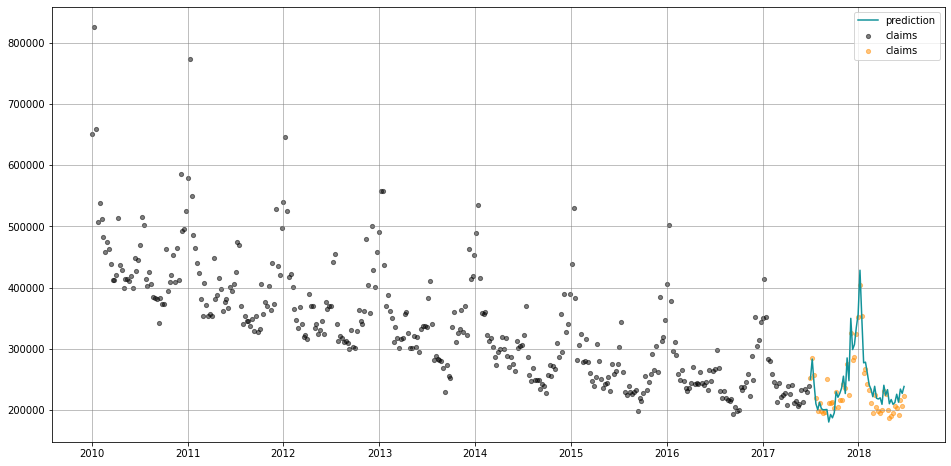

In [10]:
predicted_df = lgt_map.predict(df=test_df)
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.  Note that `pyro` takes advantage of parallel processing in `vi` and hence result in similar computation time compared to `map`.

In [12]:
lgt_vi = LGTFull(
    response_col='claims',
    date_col='week',
    seasonality=52,
    seed=8888,
    num_steps=101,
    num_sample=100,
    learning_rate=0.1,
    n_bootstrap_draws=-1,
    estimator_type=PyroEstimatorVI,
)

In [13]:
%%time
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 11.4 s, sys: 254 ms, total: 11.7 s
Wall time: 11.7 s


In [14]:
predicted_df = lgt_vi.predict(df=test_df)

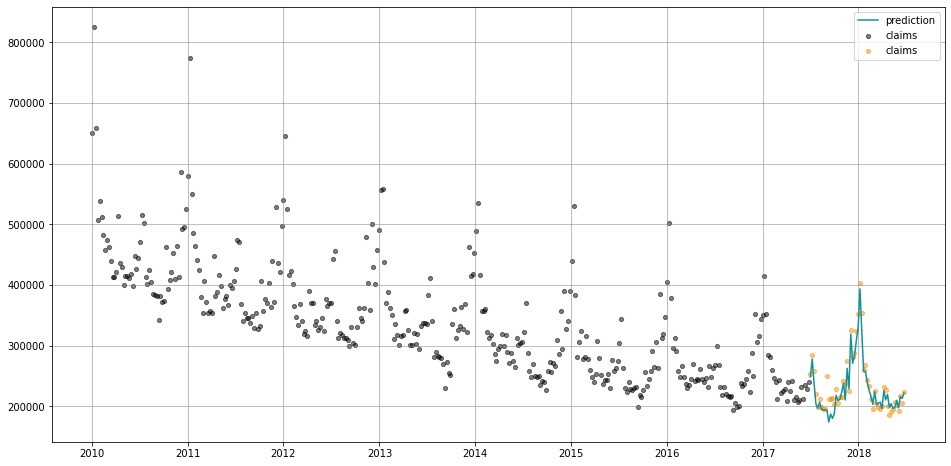

In [15]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## Fit with Regressors

### with MAP

In [16]:
lgt_reg_map = LGTMAP(
    response_col="claims",
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col="week",
    seasonality=52,
    seed=8888,
    is_multiplicative=True,
    estimator_type=PyroEstimatorMAP,
)

In [17]:
%%time
lgt_reg_map.fit(df=train_df)

CPU times: user 11.2 s, sys: 99.2 ms, total: 11.3 s
Wall time: 11.3 s


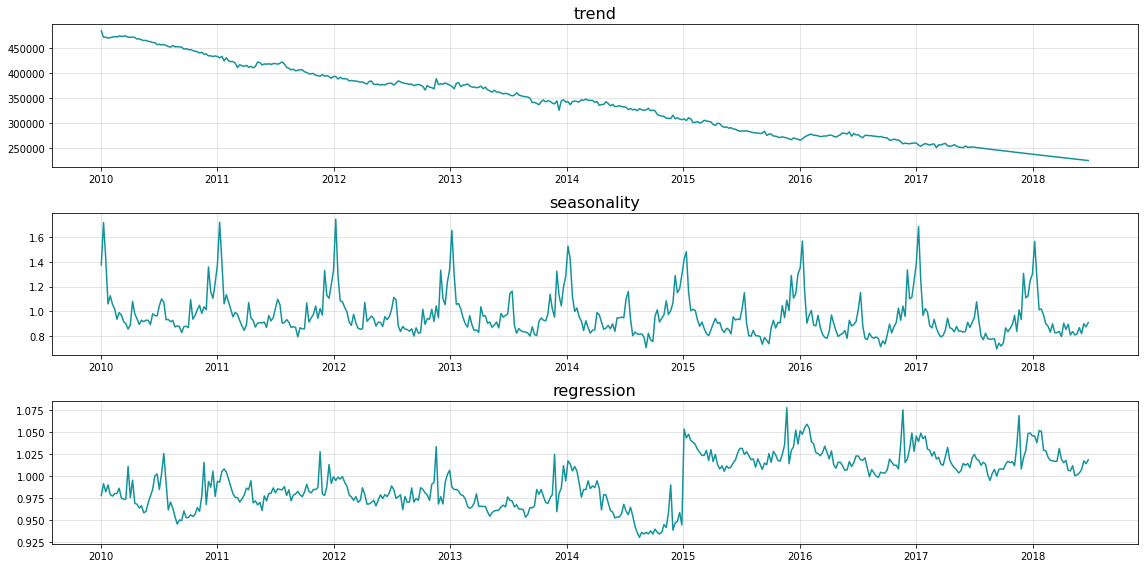

In [18]:
predicted_df = lgt_reg_map.predict(df=df,  decompose=True)
plot_predicted_components(predicted_df=predicted_df, date_col='week')

### with VI

In [19]:
lgt_reg_vi = LGTAggregated(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col='week',
    seasonality=52,
    seed=8888,
    num_steps=101,
    num_sample=100,
    learning_rate=0.1,
    estimator_type=PyroEstimatorVI,
)

In [20]:
%%time
lgt_reg_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


CPU times: user 3min 16s, sys: 5.26 s, total: 3min 21s
Wall time: 20.2 s


In [21]:
predicted_df = lgt_reg_vi.predict(df=df, decompose=True)

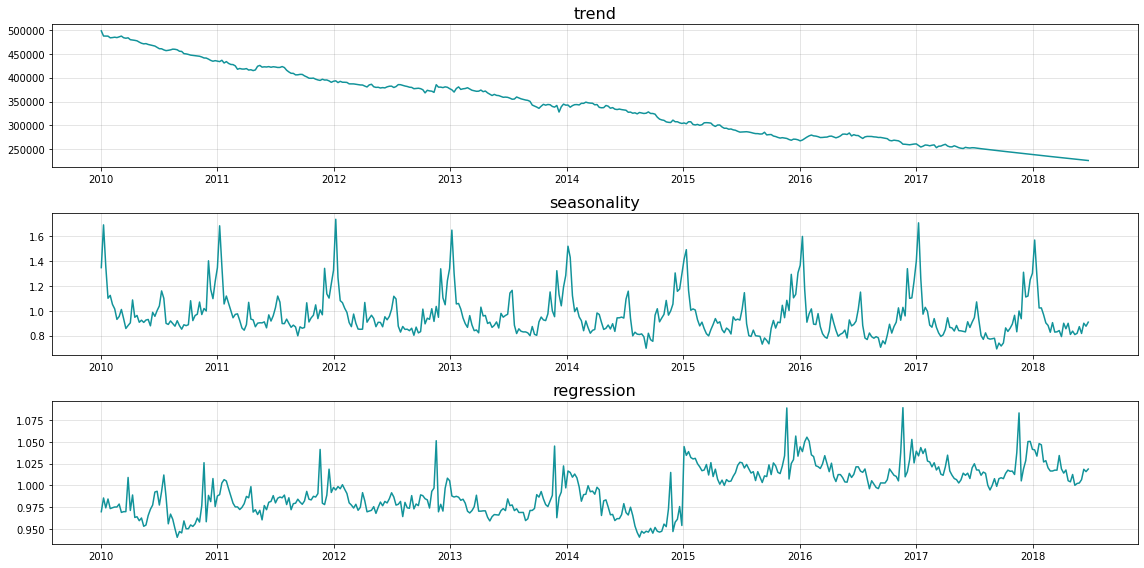

In [22]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')